# Problem 1

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import kagglehub

In [2]:
path = kagglehub.dataset_download("carlosrunner/pizza-not-pizza")

path += '\pizza_not_pizza'
print("Path to dataset files:", path)

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Shubh Sareen\AppData\Local\Temp\ipykernel_35884\181271781.py:3: SyntaxWarning: invalid escape sequence '\p'
  path += '\pizza_not_pizza'


Path to dataset files: C:\Users\Shubh Sareen\.cache\kagglehub\datasets\carlosrunner\pizza-not-pizza\versions\1\pizza_not_pizza


In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
batch_size=64
dataset = datasets.ImageFolder(path, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [4]:
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True)



In [6]:
device = torch.device(torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu")

print(device)
class ConvNet(nn.Module):
  def __init__(self):
    
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(16)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
    self.bn3 = nn.BatchNorm2d(64)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(64, 64, 3, 1, 1)
    self.bn4 = nn.BatchNorm2d(64)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.conv5 = nn.Conv2d(64, 32, 3, 1, 1)
    self.bn5 = nn.BatchNorm2d(32)
    self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(32 * 4 * 4, 256)
    self.dropout = nn.Dropout(0.3)
    self.fc2 = nn.Linear(256, 32)
    self.fc3 = nn.Linear(32, 2)
    


  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.bn1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = F.relu(self.bn2(x))
    x = self.pool2(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.bn3(x))
    x = self.pool3(x)
    x = F.relu(self.conv4(x))
    x = F.relu(self.bn4(x))
    x = self.pool4(x)
    x = F.relu(self.conv5(x))
    x = F.relu(self.bn5(x))
    x = self.pool5(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

model = ConvNet().to(device)

cuda


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    loss, current = loss.item(), batch * len(X)
    print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg Loss: {test_loss:>8f} \n")

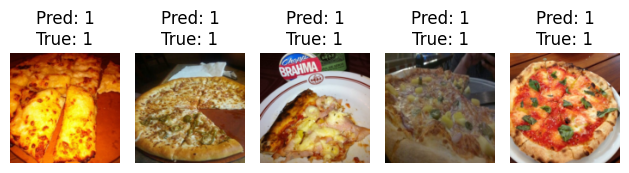

In [10]:
import matplotlib.pyplot as plt

def viz_predictions(model, dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples)
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            img, label = dataset[i]
            X = img.unsqueeze(0).to(device)
            pred = model(X)
            predicted = pred.argmax(1)
            axes[i].imshow(img.permute(1, 2, 0))
            axes[i].set_title(f'Pred: {predicted.item()}\nTrue: {label}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call visualization function
viz_predictions(model, val_dataset)

In [12]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n--------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(val_dataloader, model, loss_fn)
print("Done")

Epoch 1
--------------------
loss: 0.524217 [    0/ 1572]
loss: 0.523997 [   64/ 1572]
loss: 0.528626 [  128/ 1572]
loss: 0.563326 [  192/ 1572]
loss: 0.510647 [  256/ 1572]
loss: 0.632351 [  320/ 1572]
loss: 0.634667 [  384/ 1572]
loss: 0.594677 [  448/ 1572]
loss: 0.631737 [  512/ 1572]
loss: 0.510605 [  576/ 1572]
loss: 0.597915 [  640/ 1572]
loss: 0.595961 [  704/ 1572]
loss: 0.502611 [  768/ 1572]
loss: 0.497009 [  832/ 1572]
loss: 0.506805 [  896/ 1572]
loss: 0.564897 [  960/ 1572]
loss: 0.474687 [ 1024/ 1572]
loss: 0.501494 [ 1088/ 1572]
loss: 0.562446 [ 1152/ 1572]
loss: 0.459241 [ 1216/ 1572]
loss: 0.463545 [ 1280/ 1572]
loss: 0.601238 [ 1344/ 1572]
loss: 0.532888 [ 1408/ 1572]
loss: 0.511093 [ 1472/ 1572]
loss: 0.476905 [  864/ 1572]
Test Error: 
 Accuracy: 71.8%, Avg Loss: 0.582288 

Epoch 2
--------------------
loss: 0.530877 [    0/ 1572]
loss: 0.468203 [   64/ 1572]
loss: 0.549332 [  128/ 1572]
loss: 0.436668 [  192/ 1572]
loss: 0.454957 [  256/ 1572]
loss: 0.425737 [  32

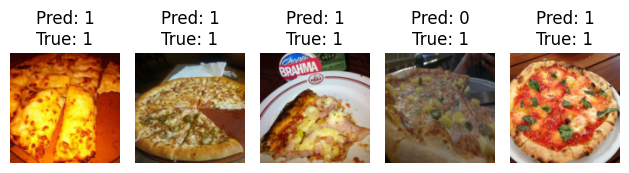

In [13]:
def viz_predictions(model, dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples)
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            img, label = dataset[i]
            X = img.unsqueeze(0).to(device)
            pred = model(X)
            predicted = pred.argmax(1)
            axes[i].imshow(img.permute(1, 2, 0))
            axes[i].set_title(f'Pred: {predicted.item()}\nTrue: {label}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call visualization function
viz_predictions(model, val_dataset)

# Problem 2

In [14]:
import torch
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import kagglehub

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pankrzysiu/cifar10-python")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Shubh Sareen\.cache\kagglehub\datasets\pankrzysiu\cifar10-python\versions\1


### Not separating the dataset because it is already separated

In [16]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
batch_size = 64
train_dataset = datasets.CIFAR10(root=path, train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10(root=path, train=False, download=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)


In [17]:
class TransferLearning(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(16, 3, kernel_size=3, padding=1)
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(2048, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 32)
        self.fc3 = nn.Linear(32, classes)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.resnet(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransferLearning().to(device)

C:\Users\Shubh Sareen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Shubh Sareen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [19]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if batch % 100 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"Loss: {loss:>7f} [{current:>5d} / {size:>5d}]")

In [20]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg Loss: {test_loss:>8f} \n")

# Before Training

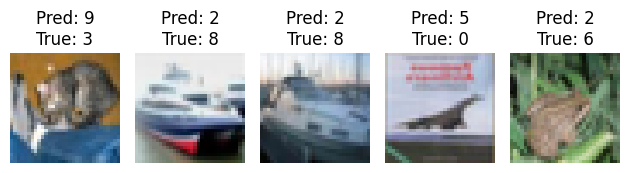

In [21]:
def viz_predictions(model, dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples)
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            img, label = dataset[i]
            X = img.unsqueeze(0).to(device)
            pred = model(X)
            predicted = pred.argmax(1)
            axes[i].imshow(img.permute(1, 2, 0))
            axes[i].set_title(f'Pred: {predicted.item()}\nTrue: {label}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call visualization function
viz_predictions(model, test_dataset)

In [22]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n--------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done")

Epoch 1
--------------------
Loss: 2.323345 [   64 / 50000]
Loss: 2.279510 [ 6464 / 50000]
Loss: 2.147561 [12864 / 50000]
Loss: 2.033082 [19264 / 50000]
Loss: 1.993959 [25664 / 50000]
Loss: 1.781931 [32064 / 50000]
Loss: 1.813769 [38464 / 50000]
Loss: 1.583284 [44864 / 50000]
Test Error: 
 Accuracy: 47.8%, Avg Loss: 1.543151 

Epoch 2
--------------------
Loss: 1.590363 [   64 / 50000]
Loss: 1.270135 [ 6464 / 50000]
Loss: 1.483835 [12864 / 50000]
Loss: 1.223606 [19264 / 50000]
Loss: 1.280427 [25664 / 50000]
Loss: 1.362213 [32064 / 50000]
Loss: 1.001894 [38464 / 50000]
Loss: 1.313847 [44864 / 50000]
Test Error: 
 Accuracy: 59.7%, Avg Loss: 1.170631 

Epoch 3
--------------------
Loss: 1.297161 [   64 / 50000]
Loss: 1.086116 [ 6464 / 50000]
Loss: 1.100849 [12864 / 50000]
Loss: 1.128180 [19264 / 50000]
Loss: 1.326678 [25664 / 50000]
Loss: 0.936704 [32064 / 50000]
Loss: 1.206615 [38464 / 50000]
Loss: 0.954314 [44864 / 50000]
Test Error: 
 Accuracy: 64.6%, Avg Loss: 1.025450 

Epoch 4
-----

# After Training

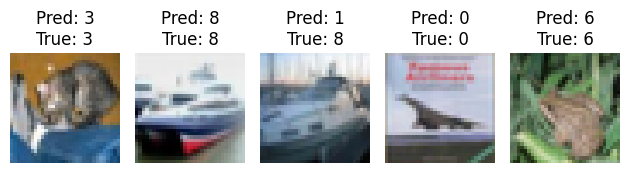

In [23]:
def viz_predictions(model, dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples)
    model.eval()
    with torch.no_grad():
        for i in range(num_samples):
            img, label = dataset[i]
            X = img.unsqueeze(0).to(device)
            pred = model(X)
            predicted = pred.argmax(1)
            axes[i].imshow(img.permute(1, 2, 0))
            axes[i].set_title(f'Pred: {predicted.item()}\nTrue: {label}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Call visualization function
viz_predictions(model, test_dataset)